In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import scipy.special
sys.path.insert(0, "../../../knockpy-dev/knockpy/")
import knockpy
print(knockpy.__version__)
from knockpy.knockoff_filter import KnockoffFilter as KF
sys.path.insert(0, "../")
from mlr_src import gen_data
import warnings
from plotnine import *

def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

1.3.0


### Contribution plot

In [15]:
dates = ['2022-08-26' for _ in range(4)]
#times = ['16-00-40', '16-01-05', '16-11-47', '16-11-58']
#equi = [False, False, False, True]
#times = ['18-58-13', '18-59-06', '19-09-36', '19-10-29']
#times = ['22-05-12', '22-05-39', '22-16-16', '22-18-27']
times = ['23-01-59', '22-05-39', '23-21-25', '22-18-27']
equi = [False, True, False, False]
dfs = []
for d, t, equiflag in zip(dates, times, equi):
    df = pd.read_csv(f"../data/main/{d}/{t}/results.csv")
    if equiflag:
        df['covmethod'] = 'equi'
    dfs.append(df)
all_df = pd.concat(dfs)
all_df['mx'] = all_df['mx'].astype(str).map({"True":"MX", "False":"FX"})
all_df['fstat'] = all_df['fstat'].map({
    "mlr":'MLR', 
    "lcd":"LCD", "lsm":"LSM", 
    "oracle":"MLR\n(oracle)", 
})
all_df['Knockoff_Type'] = all_df['knockoff_type'].str.upper().map(
    {"MVR":"MRC", "SDP":"Standard\n(SDP)\n"}
)
all_df['covmethod'] = all_df['covmethod'].map({
    "ar1":"AR1", 
    "ver":"ErdosRenyi",
    "equi":"Equicorr.",
    "blockequi":"Block equi."
})
all_df['oracle'] = all_df['fstat'].str.contains("oracle")
all_df = all_df.loc[
    (all_df['n'] >= 125) &
    (~all_df['oracle'])
]
all_df['fstat'] = all_df['fstat'].map(
    {"LCD":"Lasso", "MLR":"MLR"}
)
#all_df['fstat'] = all_df['fstat'] + all_df['Knockoff_Type'].apply(lambda x: ' ' if x == 'SDP' else '')

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


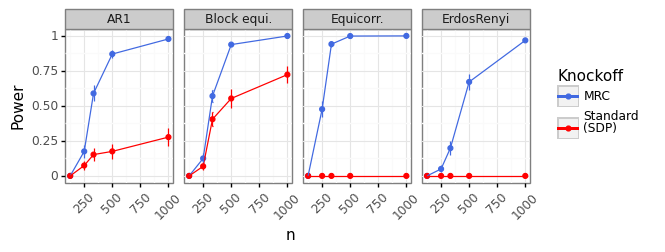

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/contrib_plot_onlylasso.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [41]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'Knockoff_Type', 'fstat', 'q', 
        'coeff_size', 'sparsity', 'covmethod', 'oracle'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)

meas = 'power'
g = (
    ggplot(
        agg_df.loc[
            (agg_df['q'].isin([0.05])) &
            (agg_df['fstat'].str.contains("Lasso"))
        ],
        aes(x='n', y=f"{meas}_mean", color='Knockoff_Type', group='fstat+Knockoff_Type')
    ) + 
    geom_point(aes(shape='fstat')) +
    geom_line(aes(linetype='fstat')) +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax")) +
    facet_grid("~covmethod", scales='free_x') +
    theme_bw() + 
    theme(
        figure_size=(6,2), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10, 'hspace':0.12},
    ) +
    labs(
        #title="Power for Gaussian linear models", 
        y='Power', x='n', color='Knockoff',
        linetype=None,#'Feature\nStat\n',
        shape=None,#'Feature\nStat\n',
    ) +
    #scale_color_manual(['red', 'orange', 'royalblue', 'cornflowerblue']) +
    scale_color_manual(['royalblue', 'red']) +
    scale_linetype_manual(values=['solid', 'dotted'], guide=False) +
    scale_shape_manual(values=['o'], guide=False)
    #scale_color_manual(['blue', 'red', 'orange', 'cornflowerblue'])
)
print(g)
g.save("presentation/contrib_plot_onlylasso.png", dpi=500)


/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


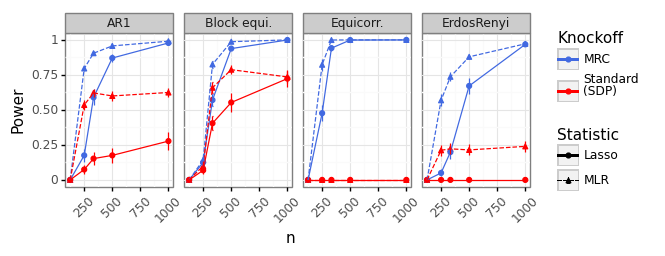

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/contrib_plot.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [42]:
agg_df = calc_mean_sem(
    all_df,
    group_vals=[
        'n', 'p', 'Knockoff_Type', 'fstat', 'q', 
        'coeff_size', 'sparsity', 'covmethod', 'oracle'
    ],
    meas=['power', 'fdp', 'ko_time', 'fstat_time'],
)

meas = 'power'
g = (
    ggplot(
        agg_df.loc[
            (agg_df['q'].isin([0.05]))
        ],
        aes(x='n', y=f"{meas}_mean", color='Knockoff_Type', group='fstat+Knockoff_Type')
    ) + 
    geom_point(aes(shape='fstat')) +
    geom_line(aes(linetype='fstat')) +
    geom_errorbar(aes(ymin=f"{meas}_ymin", ymax=f"{meas}_ymax")) +
    facet_grid("~covmethod", scales='free_x') +
    theme_bw() + 
    theme(
        figure_size=(6,2), 
        axis_text_x=element_text(rotation=45), 
        subplots_adjust={'wspace':0.10, 'hspace':0.12},
    ) +
    labs(
        #title="Power for Gaussian linear models", 
        y='Power', x='n', color='Knockoff',
        linetype='Statistic',
        shape='Statistic',
    ) +
    #scale_color_manual(['red', 'orange', 'royalblue', 'cornflowerblue']) +
    scale_color_manual(['royalblue', 'red']) +
    scale_linetype_manual(values=['solid', 'dashed'])
    #scale_color_manual(['blue', 'red', 'orange', 'cornflowerblue'])
)
print(g)
g.save("presentation/contrib_plot.png", dpi=500)


## Play the knockoffs game

Examples are completely synthetic to illustrate a point.

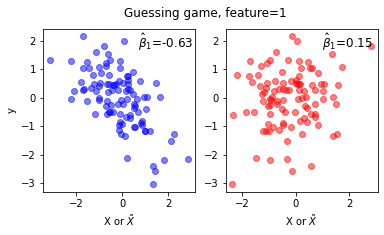

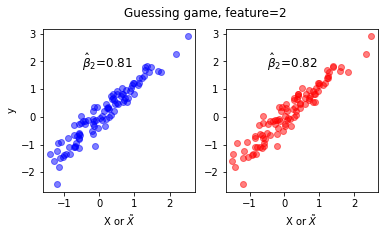

In [229]:
np.random.seed(12)
n = 100
rhos = [0.1, 0.99]#[0.99, 0.1]
betas = [-0.7, 4]
for j in range(2):
    Xj = np.random.randn(n)
    Xjk = rhos[j] * Xj + np.sqrt(1 - rhos[j]) * np.random.randn(n)
    y = betas[j] * Xj + np.random.randn(n)
    y = y / y.std()
    
    # hatbetas
    hb = np.around(Xj @ y / n, 2)
    hbk = np.around(Xjk @ y / n, 2)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].scatter(Xj, y, color='blue', alpha=0.5)
    if j == 1:
        ax[0].text(-0.5, 1.8, rf"$\hat \beta_{j+1}$={hb}", size=12)
    else:
        ax[0].text(0.7, 1.8, rf"$\hat \beta_{j+1}$={hb}", size=12)
    ax[1].scatter(Xjk, y, color='red', alpha=0.5)
    if j == 0:
        ax[1].text(1, 1.8, rf"$\hat \beta_{j+1}$={hbk}", size=12)
    else:
        ax[1].text(-0.5, 1.8, rf"$\hat \beta_{j+1}$={hbk}", size=12)
    ax[0].set(xlabel=r"X or $\tilde{X}$", ylabel="y")
    ax[1].set(xlabel=r"X or $\tilde{X}$")
    fig.suptitle(f"Guessing game, feature={j+1}")
    plt.savefig(f"presentation/guessing_game/feature{j}.png", dpi=500, bbox_inches='tight')

## HIV motivation, guessing game variant

/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/geoms/geom_rect.py:62: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is depreca

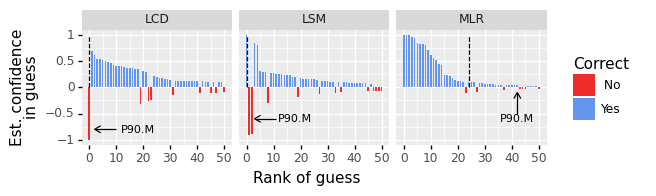

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 3 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: presentation/guessing_game/wstat_plot_hiv.png
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/asher/.local/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be r

In [242]:
drug_type = 'PI'
drug = 'IDV'

Wdf = pd.read_csv("../real_data/hiv_data/results/W_sorted.csv")
Tdf = pd.read_csv("../real_data/hiv_data/results/thresholds.csv")
Wdf = Wdf.loc[(Wdf['drug'] == drug) & (Wdf['knockoff_type'] == 'sdp')]
Wdf['correct'] = (Wdf['W'] > 0).apply(lambda x: 'Yes' if x else ' No')
Tdf = Tdf.loc[(Tdf['drug'] == drug) & (Tdf['knockoff_type'] == 'sdp')]
Tdf['correct'] = ' No'


arrows = pd.DataFrame(columns=['rank', 'W', 'fstat'])
arrows['rank'] = [10, 2, 11, 3, 42, 42]
arrows['W'] = [-0.8, -0.8, -0.6, -0.6, -0.5, -0.1]
arrows['fstat'] = ['LCD', 'LCD', 'LSM', 'LSM', 'MLR', 'MLR']
arrows['correct'] = ' No'

text_data = pd.DataFrame(columns=['rank', 'W', 'fstat'])
text_data['rank'] = [18, 18, 42]
text_data['W'] = [-0.8, -0.6, -0.6]
text_data['fstat'] = ['LCD', 'LSM', 'MLR']
text_data['text'] = ['P90.M', 'P90.M', 'P90.M']
text_data['correct'] = ' No'

g = (ggplot(
    Wdf[Wdf['rank'] <= 50], aes(x='rank', y='W', fill='correct')
) + geom_col(width=0.6)
  + geom_segment(
      data = Tdf,
      mapping=aes(
          x='rank',
          xend='rank',
          y=0.0,
          yend=1.0,
          inherit_aes=False,
      ), 
      linetype='dashed', color='black',
  )
  + geom_path(
    data=arrows,
      arrow=arrow(length=0.07),
  )
  + geom_text(
    data=text_data,
    mapping=aes(label='text'),
    size=8
  )
  + facet_grid('~fstat')
  + labs(x=f'Rank of guess', y=f'Est. confidence\nin guess')#, title='LCD Statistics for MVR and SDP, Equicorrelated Gaussian Designs')
  + guides(
      linetype = None,
      #guide_legend(title=''),
      fill = guide_legend(title='Correct'),
      color = None,#guide_legend(title='Null'),
  )
  + scale_color_manual(values=('#ee2c2c', 'cornflowerblue'))
  + scale_fill_manual(values=('#ee2c2c', 'cornflowerblue'))
  + theme(figure_size=(6,1.5))
)
print(g)
#g.save("section2/wstat_plot_hiv.png", dpi=500)
g += theme(figure_size=(6,3))
g.save("presentation/guessing_game/wstat_plot_hiv.png", dpi=500)

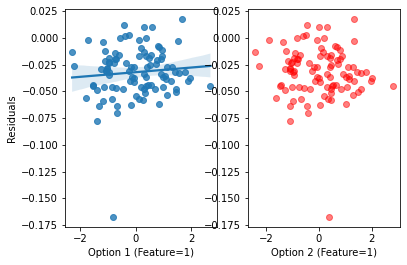

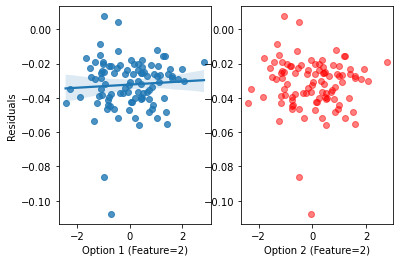

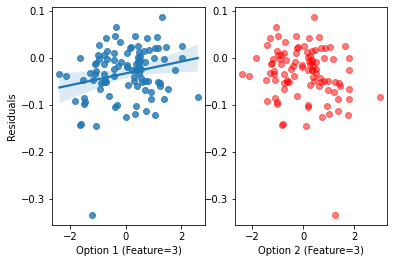

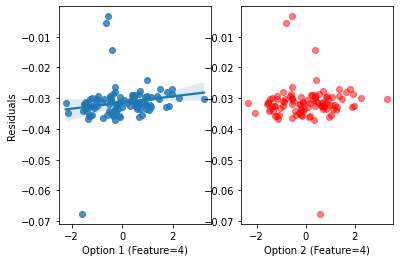

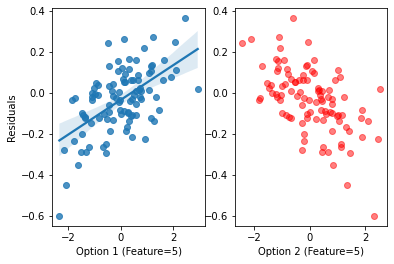

In [128]:
for j in range(p):
    fig, ax = plt.subplots(1, 2)

    # create residuals
    negj = [i for i in range(p) if i != j]
    fj = np.concatenate([kf.X[:, negj], kf.Xk[:, negj]], axis=1)
    Hj = fj @ np.linalg.inv(fj.T @ fj) @ fj.T
    resid = y - Hj @ y

    # hello
    sns.regplot(kf.X[:, j], resid, ax=ax[0])
    #ax[0].scatter(kf.X[:, j], resid, color='blue', alpha=0.5)
    ax[1].scatter(kf.Xk[:, j], resid, color='red', alpha=0.5)
    ax[0].set(xlabel=f"Option 1 (Feature={j+1})", ylabel="Residuals")
    ax[1].set(xlabel=f"Option 2 (Feature={j+1})")
    plt.show()

## Code snippet

In [16]:
X = np.random.randn(1000, 100)
y = np.random.randn(1000)
Sigma = np.cov(X)

In [31]:
from knockpy import KnockoffFilter as KF

In [35]:
# Traditional method
kf = KF(fstat='lcd', knockoff_kwargs={"method":"sdp"})
rejections = kf.forward(X=X, y=y)

In [34]:
# Methods from this talk
kf_new = KF(fstat='mlr', knockoff_kwargs={"method":"mvr"})
rejections = kf.forward(X=X, y=y)

In [48]:
# t-tailed Markov chain with MLR spline importances
kf_splines = KF(
    fstat='mlr_spline',
    ksampler='artk', knockoff_kwargs={"df_t":3}
)
rej_splines = kf_splines.forward(X=X, y=y)

In [106]:
n, p = 250, 500
# data-generating processes
np.random.seed(123)
dgproc = knockpy.dgp.DGP()
dgproc.sample_data(
    n=n,
    p=p,
    method='equi',
    gamma=0,
    sparsity=1.0,
    coeff_size=1.0,
    coeff_dist='normal',
)
kf = KF(fstat='mlr', ksampler='gaussian')
mlr_rej = kf.forward(
    X=dgproc.X, y=dgproc.y, Sigma=dgproc.Sigma,
)

In [98]:
kf.fstat.p0s

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [101]:
kf.fstat.sigma2s

array([0.6522459 , 0.63205977, 0.63486422, ..., 0.00181183, 0.00193728,
       0.00222842])

In [95]:
kf.fstat.tau2s

array([2.38530881, 1.986391  , 2.0829131 , ..., 1.98013667, 1.89013888,
       1.97156954])

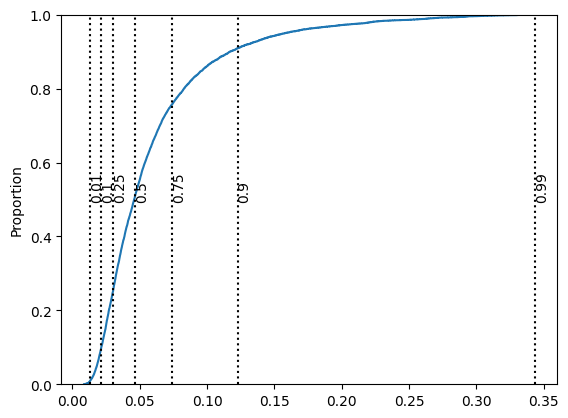

In [132]:
from scipy import stats
import matplotlib.pyplot as plt

rvs = stats.invgamma(2.5, scale=0.1).rvs(10000)
quants = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
quantvals = np.quantile(rvs, quants)
fig, ax = plt.subplots()
sns.ecdfplot(rvs[rvs <= quantvals.max()], ax=ax)
for q, qv in zip(quants, quantvals):
    ax.axvline(qv, color='black', linestyle='dotted')
    ax.text(qv, 0.5, q, rotation=90)